# Problem definition 

In this project we aim to study and predict the flight delays at take offs.

# Main Aspects 
## Identify dataset 
  
- Downloaded data from Kaggle (2015) 
SOURCE LINKS  - https://www.kaggle.com/usdot/flight-delays
- Downloaded data from DOT (2019) 
SOURCE LINKS  - https://www.transtats.bts.gov/DL_SelectFields.asp?Table_ID=236
    
## Cleaning and data transformation 
- Definition of terms
- Transforming data - conversion of dates to panda format, 


## Discovery of patterns 
- Flight Speed of each airline 
- Mean flight delay of each airline
- Mean taxi out and taxi in time
- Arrival delay vs airline


## Visualization of key factors 
- Departure Delay vs Departure time :
    After pattern discovery we realized that we would have to model based on each airport and each airline(at that airport)


## Predictive Modeling 
For predictive modeling we used the following models 
- Linear Regression 
- Polynomial Regression 



# Final Recommendations

## - Predict departure delay with departure time, given an airline 
## - Ranked which airline has the best ontime performance 


- REFERENCES

https://www.kaggle.com/fabiendaniel/predicting-flight-delays-tutorial

https://www.kaggle.com/utkarshagrawal/insights-and-ranking-module-of-airlines

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import math
import os
import datetime, warnings, scipy 
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from matplotlib.patches import ConnectionPatch

from matplotlib.gridspec import GridSpec

from collections import OrderedDict
from sklearn import metrics, linear_model

from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict
from scipy.optimize import curve_fit

from sklearn.metrics import r2_score

from collections import OrderedDict

plt.rcParams["patch.force_edgecolor"] = True
plt.style.use('fivethirtyeight')
mpl.rc('patch', edgecolor = 'dimgray', linewidth=1)
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "last_expr"
pd.options.display.max_columns = 50
%matplotlib inline
warnings.filterwarnings("ignore")


## Load dataset 

In [2]:
##import csv ,find dimensions
#FilePath = 'E:\\WinPython\\notebooks\\'
Filename = 'flight_delay_2019_header_rename.csv'
df = pd.read_csv(Filename, low_memory=False)
print('Dataframe dimensions:', df.shape)
print(df.head())


Dataframe dimensions: (583985, 64)
   YEAR  MONTH  DAY  DAY_OF_WEEK FlightDate AIRLINE  DOT_ID_Reporting_Airline  \
0  2019      1    4            5   1/4/2019      OO                     20304   
1  2019      1    4            5   1/4/2019      OO                     20304   
2  2019      1    4            5   1/4/2019      OO                     20304   
3  2019      1    4            5   1/4/2019      OO                     20304   
4  2019      1    4            5   1/4/2019      OO                     20304   

  IATA_CODE_Reporting_Airline TAIL_NUMBER  FLIGHT_NUMBER  OriginAirportID  \
0                          OO      N945SW           5657            14698   
1                          OO      N932SW           5658            12266   
2                          OO      N932SW           5658            14783   
3                          OO      N916SW           5659            12389   
4                          OO      N107SY           5660            13342   

   OriginAirpor

## Format dataset

In [3]:
def format_hour(in_hour):
    if pd.isnull(in_hour):
        return np.nan
    else:
        if in_hour == 2400: in_hour = 0
        in_hour = "{0:04d}".format(int(in_hour))
        hour = datetime.time(int(in_hour[0:2]), int(in_hour[2:4]))
        return hour
#_____________________________________________________________________
# Function that combines a date and time to produce a datetime.datetime
def combine_date_hour(x):
    if pd.isnull(x[0]) or pd.isnull(x[1]):
        return np.nan
    else:
        return datetime.datetime.combine(x[0],x[1])
#_______________________________________________________________________________
# Function that combine two columns of the dataframe to create a datetime format
def create_flight_time(df, col):    
    liste = []
    for index, cols in df[['DATE', col]].iterrows():    
        if pd.isnull(cols[1]):
            liste.append(np.nan)
        elif float(cols[1]) == 2400:
            cols[0] += datetime.timedelta(days=1)
            cols[1] = datetime.time(0,0)
            liste.append(combine_date_hour(cols))
        else:
            cols[1] = format_hour(cols[1])
            liste.append(combine_date_hour(cols))
    return pd.Series(liste)

In [4]:
df['DATE'] = pd.to_datetime(df[['YEAR','MONTH', 'DAY']])
df['SCHEDULED_DEPARTURE'] = create_flight_time(df, 'SCHEDULED_DEPARTURE')
df['DEPARTURE_TIME'] = df['DEPARTURE_TIME'].apply(format_hour)
df['SCHEDULED_ARRIVAL'] = df['SCHEDULED_ARRIVAL'].apply(format_hour)
df['ARRIVAL_TIME'] = df['ARRIVAL_TIME'].apply(format_hour)

df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']]
print(df.loc[:5, ['SCHEDULED_DEPARTURE', 'SCHEDULED_ARRIVAL', 'DEPARTURE_TIME',
             'ARRIVAL_TIME', 'DEPARTURE_DELAY', 'ARRIVAL_DELAY']])


  SCHEDULED_DEPARTURE SCHEDULED_ARRIVAL DEPARTURE_TIME ARRIVAL_TIME  \
0 2019-01-04 14:00:00          15:10:00       13:53:00     14:44:00   
1 2019-01-04 09:35:00          11:18:00       09:30:00     11:19:00   
2 2019-01-04 06:43:00          08:55:00       06:37:00     08:38:00   
3 2019-01-04 13:35:00          14:33:00       13:14:00     14:04:00   
4 2019-01-04 08:36:00          10:40:00       08:26:00     10:09:00   
5 2019-01-04 16:10:00          18:26:00       16:00:00     18:14:00   

   DEPARTURE_DELAY  ARRIVAL_DELAY  
0             -7.0          -26.0  
1             -5.0            1.0  
2             -6.0          -17.0  
3            -21.0          -29.0  
4            -10.0          -31.0  
5            -10.0          -12.0  


In [5]:
print("Reached here")

Reached here


## Cleaning and data transformation

In [6]:
df = df[['AIRLINE', 'ORIGIN_AIRPORT', 'DESTINATION_AIRPORT',
        'SCHEDULED_DEPARTURE', 'DEPARTURE_TIME', 'DEPARTURE_DELAY',
        'SCHEDULED_ARRIVAL', 'ARRIVAL_TIME', 'ARRIVAL_DELAY','ELAPSED_TIME']]
 #removed 'SCHEDULED_TIME' since it is not in 2019
df2 = df.copy()


In [7]:
missing_df = df2.isnull().sum(axis=0).reset_index()
missing_df.columns = ['variable', 'missing values']
missing_df['filling factor (%)']=(df2.shape[0]-missing_df['missing values'])/df2.shape[0]*100
missing_df.sort_values('filling factor (%)').reset_index(drop = True)

df2.dropna(inplace = True)

## Discovery of patterns

In [8]:
airline_csv = 'airlines_2019.csv'
airlines_names = pd.read_csv(airline_csv)
print('Dataframe dimensions:', airlines_names.shape)
print(airlines_names.head())

Dataframe dimensions: (18, 2)
  IATA_CODE                 AIRLINE
0        9E            Endeavor Air
1        UA   United Air Lines Inc.
2        AA  American Airlines Inc.
3        AS    Alaska Airlines Inc.
4        G4       Allegiant Air LLC


In [9]:
#For further use, I put the content of this  dataframe in a dictionary:
abbr_companies = airlines_names.set_index('IATA_CODE')['AIRLINE'].to_dict()

In [10]:
#__________________________________________________________________
# function that extract statistical parameters from a grouby object:
def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}
#_______________________________________________________________
# Creation of a dataframe with statitical infos on each airline:
global_stats = df['DEPARTURE_DELAY'].groupby(df['AIRLINE']).apply(get_stats).unstack()
global_stats = global_stats.sort_values('count')


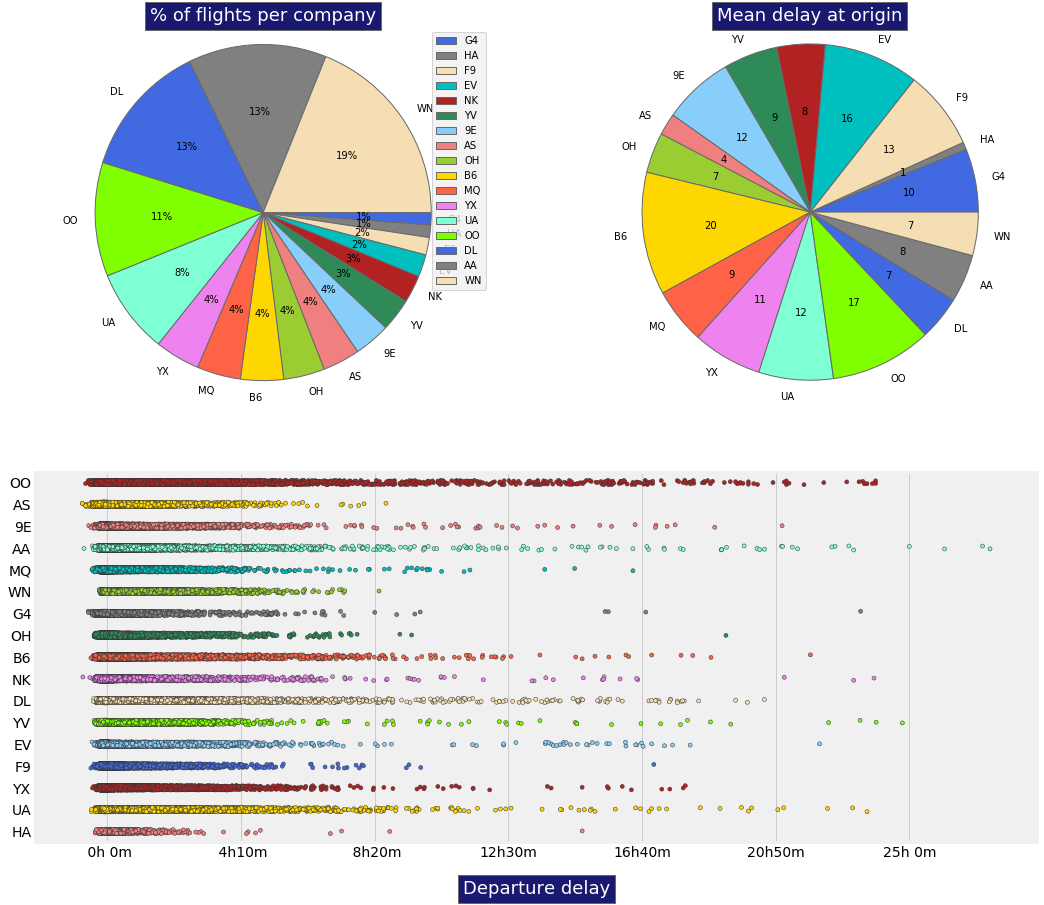

In [11]:
import matplotlib.patches as mpatches
fig = plt.figure(1, figsize=(16,15))
gs=GridSpec(2,2)             
ax1=fig.add_subplot(gs[0,0]) 
ax2=fig.add_subplot(gs[0,1]) 
ax3=fig.add_subplot(gs[1,:]) 
# array of colors
colors = ['royalblue', 'grey', 'wheat', 'c', 'firebrick', 'seagreen', 'lightskyblue',
          'lightcoral', 'yellowgreen', 'gold', 'tomato', 'violet', 'aquamarine', 'chartreuse']
labels = [s for s in  global_stats.index]
sizes  = global_stats['count'].values
#___________________________________________________________________
# autopct the %.1f is Python formating and %% used to show as percent
patches, texts, autotexts = ax1.pie(sizes, colors=colors, labels=labels, autopct='%1.0f%%',
        counterclock=False, shadow=False)

ax1.axis('equal')
ax1.set_title('% of flights per company', bbox={'facecolor':'midnightblue', 'pad':5},
              color = 'w',fontsize=18)

#___________________________________________________________________
sizes  = global_stats['mean'].values
sizes  = [max(s,0) for s in sizes]

patches, texts, autotexts = ax2.pie(sizes, labels = labels,
                                colors = colors, shadow=False, 
                                autopct = lambda p :  '{:.0f}'.format(p * sum(sizes) / 100))
ax2.axis('equal')
ax2.set_title('Mean delay at origin', bbox={'facecolor':'midnightblue', 'pad':5},
              color='w', fontsize=18)

# I redefine the colors for correspondance with the pie charts
colors = ['firebrick', 'gold', 'lightcoral', 'aquamarine', 'c', 'yellowgreen', 'grey',
          'seagreen', 'tomato', 'violet', 'wheat', 'chartreuse', 'lightskyblue', 'royalblue']
#___________________________________________________________________
ax3 = sns.stripplot(y="AIRLINE", x="DEPARTURE_DELAY", size = 4, palette = colors,
                    data=df2, linewidth = 0.5,  jitter=True)
plt.setp(ax3.get_xticklabels(), fontsize=14)
plt.setp(ax3.get_yticklabels(), fontsize=14)
ax3.set_xticklabels(['{:2.0f}h{:2.0f}m'.format(*[int(y) for y in divmod(x,60)])
                         for x in ax3.get_xticks()])
plt.xlabel('Departure delay', fontsize=18, bbox={'facecolor':'midnightblue', 'pad':5},
           color='w', labelpad=20)
ax3.yaxis.label.set_visible(False)
#___________________________________________________________________
#This part is not working which shows legend with airline name
#
#comp_handler = []
#for i in range(len(abbr_companies)):
#    comp_handler.append(mpatches.Patch(color=colors[i],
#            label = global_stats.index[i] + ': ' + abbr_companies[global_stats.index[i]]))
#ax1.legend(handles=comp_handler, bbox_to_anchor=(0.2, 0.9), 
#           fontsize = 13, bbox_transform=plt.gcf().transFigure)

ax1.legend()
plt.show()

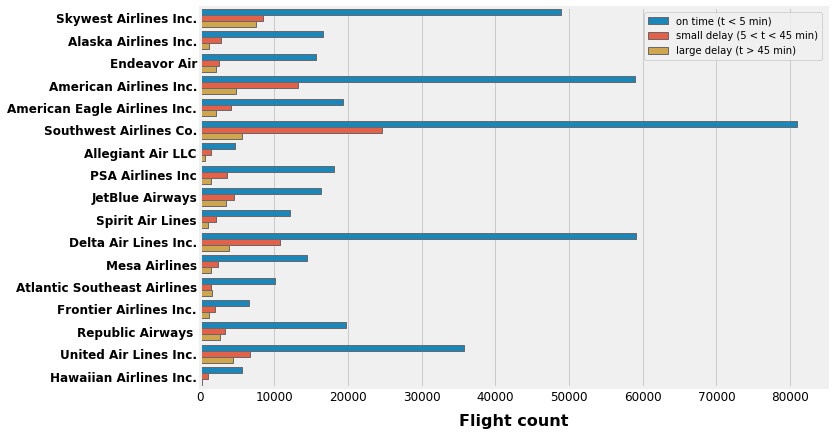

In [12]:
#_____________________________________________
# Function that define how delays are grouped
delay_type = lambda x:((0,1)[x > 5],2)[x > 45]
df['DELAY_LEVEL'] = df['DEPARTURE_DELAY'].apply(delay_type)
#____________________________________________________
fig = plt.figure(1, figsize=(10,7))
ax = sns.countplot(y="AIRLINE", hue='DELAY_LEVEL', data=df)
#____________________________________________________________________________________
# We replace the abbreviations by the full names of the companies and set the labels
labels = [abbr_companies[item.get_text()] for item in ax.get_yticklabels()]
ax.set_yticklabels(labels)
plt.setp(ax.get_xticklabels(), fontsize=12, weight = 'normal', rotation = 0);
plt.setp(ax.get_yticklabels(), fontsize=12, weight = 'bold', rotation = 0);
ax.yaxis.label.set_visible(False)
plt.xlabel('Flight count', fontsize=16, weight = 'bold', labelpad=10)
#________________
# Set the legend
L = plt.legend()
L.get_texts()[0].set_text('on time (t < 5 min)')
L.get_texts()[1].set_text('small delay (5 < t < 45 min)')
L.get_texts()[2].set_text('large delay (t > 45 min)')
plt.show()

In [13]:
airports = pd.read_csv('airports.csv')
print(airports.head())

  IATA_CODE                              AIRPORT         CITY STATE COUNTRY  \
0       ABE  Lehigh Valley International Airport    Allentown    PA     USA   
1       ABI             Abilene Regional Airport      Abilene    TX     USA   
2       ABQ    Albuquerque International Sunport  Albuquerque    NM     USA   
3       ABR            Aberdeen Regional Airport     Aberdeen    SD     USA   
4       ABY   Southwest Georgia Regional Airport       Albany    GA     USA   

   LATITUDE  LONGITUDE  
0  40.65236  -75.44040  
1  32.41132  -99.68190  
2  35.04022 -106.60919  
3  45.44906  -98.42183  
4  31.53552  -84.19447  


In [14]:
#For further use, I put the content of this this dataframe in a dictionary:
abbr_companies = airports.set_index('IATA_CODE')['AIRPORT'].to_dict()


## FACT DISCOVERY

In [15]:
airlines = pd.read_csv(r'airlines_2019.csv')
flights = pd.read_csv(r'flight_delay_2019_header_rename.csv')

In [16]:
flights.columns.get_loc('FirstDepTime')
flights.drop(flights.iloc[:, 61:],axis=1,inplace=True)
flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FlightDate,AIRLINE,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,TAIL_NUMBER,FLIGHT_NUMBER,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,ORIGIN_AIRPORT,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DESTINATION_AIRPORT,DestCityName,DestState,...,WHEELS_OFF,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CANCELLED,CancellationCode,DIVERTED,CRSElapsedTime,ELAPSED_TIME,AIR_TIME,Flights,DISTANCE,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime
0,2019,1,4,5,1/4/2019,OO,20304,OO,N945SW,5657,14698,1469802,34236,SBP,"San Luis Obispo, CA",CA,6,California,91,14771,1477104,32457,SFO,"San Francisco, CA",CA,...,1402.0,1439.0,5.0,1510,1444.0,-26.0,0.0,0.0,-2.0,1500-1559,0,NaN,0,70.0,51.0,37.0,1,190,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,1,4,5,1/4/2019,OO,20304,OO,N932SW,5658,12266,1226603,31453,IAH,"Houston, TX",TX,48,Texas,74,15919,1591904,31834,XNA,"Fayetteville, AR",AR,...,957.0,1113.0,6.0,1118,1119.0,1.0,1.0,0.0,0.0,1100-1159,0,NaN,0,103.0,109.0,76.0,1,438,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,1,4,5,1/4/2019,OO,20304,OO,N932SW,5658,14783,1478302,34783,SGF,"Springfield, MO",MO,29,Missouri,64,12266,1226603,31453,IAH,"Houston, TX",TX,...,654.0,822.0,16.0,855,838.0,-17.0,0.0,0.0,-2.0,0800-0859,0,NaN,0,132.0,121.0,88.0,1,513,3,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,1,4,5,1/4/2019,OO,20304,OO,N916SW,5659,12389,1238902,32389,ISN,"Williston, ND",ND,38,North Dakota,66,11292,1129202,30325,DEN,"Denver, CO",CO,...,1337.0,1357.0,7.0,1433,1404.0,-29.0,0.0,0.0,-2.0,1400-1459,0,NaN,0,118.0,110.0,80.0,1,576,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,1,4,5,1/4/2019,OO,20304,OO,N107SY,5660,13342,1334207,33342,MKE,"Milwaukee, WI",WI,55,Wisconsin,45,11292,1129202,30325,DEN,"Denver, CO",CO,...,852.0,959.0,10.0,1040,1009.0,-31.0,0.0,0.0,-2.0,1000-1059,0,NaN,0,184.0,163.0,127.0,1,896,4,NaN,NaN,NaN,NaN,NaN,NaN


In [17]:
#remove_columns=['DOT_ID_Reporting_Airline','IATA_CODE_Reporting_Airline','FLIGHT_NUMBER','OriginAirportID','OriginAirportSeqID','OriginCityMarketID','OriginStateFips','OriginWac','DestAirportID','DestAirportSeqID','DestCityMarketID','DestStateFips','DestStateName','DestWac','DepartureDelayGroups','DepTimeBlk','ArrivalDelayGroups','ArrTimeBlk']
#flights.drop(remove_columns, inplace=True, axis=1)
new_flights=flights.copy()
new_flights.head()

,YEAR,MONTH,DAY,DAY_OF_WEEK,FlightDate,AIRLINE,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,TAIL_NUMBER,FLIGHT_NUMBER,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,ORIGIN_AIRPORT,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DESTINATION_AIRPORT,DestCityName,DestState,...,WHEELS_OFF,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CANCELLED,CancellationCode,DIVERTED,CRSElapsedTime,ELAPSED_TIME,AIR_TIME,Flights,DISTANCE,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime
0,2019,1,4,5,1/4/2019,OO,20304,OO,N945SW,5657,14698,1469802,34236,SBP,"San Luis Obispo, CA",CA,6,California,91,14771,1477104,32457,SFO,"San Francisco, CA",CA,...,1402.0,1439.0,5.0,1510,1444.0,-26.0,0.0,0.0,-2.0,1500-1559,0,NaN,0,70.0,51.0,37.0,1,190,1,NaN,NaN,NaN,NaN,NaN,NaN
1,2019,1,4,5,1/4/2019,OO,20304,OO,N932SW,5658,12266,1226603,31453,IAH,"Houston, TX",TX,48,Texas,74,15919,1591904,31834,XNA,"Fayetteville, AR",AR,...,957.0,1113.0,6.0,1118,1119.0,1.0,1.0,0.0,0.0,1100-1159,0,NaN,0,103.0,109.0,76.0,1,438,2,NaN,NaN,NaN,NaN,NaN,NaN
2,2019,1,4,5,1/4/2019,OO,20304,OO,N932SW,5658,14783,1478302,34783,SGF,"Springfield, MO",MO,29,Missouri,64,12266,1226603,31453,IAH,"Houston, TX",TX,...,654.0,822.0,16.0,855,838.0,-17.0,0.0,0.0,-2.0,0800-0859,0,NaN,0,132.0,121.0,88.0,1,513,3,NaN,NaN,NaN,NaN,NaN,NaN
3,2019,1,4,5,1/4/2019,OO,20304,OO,N916SW,5659,12389,1238902,32389,ISN,"Williston, ND",ND,38,North Dakota,66,11292,1129202,30325,DEN,"Denver, CO",CO,...,1337.0,1357.0,7.0,1433,1404.0,-29.0,0.0,0.0,-2.0,1400-1459,0,NaN,0,118.0,110.0,80.0,1,576,3,NaN,NaN,NaN,NaN,NaN,NaN
4,2019,1,4,5,1/4/2019,OO,20304,OO,N107SY,5660,13342,1334207,33342,MKE,"Milwaukee, WI",WI,55,Wisconsin,45,11292,1129202,30325,DEN,"Denver, CO",CO,...,852.0,959.0,10.0,1040,1009.0,-31.0,0.0,0.0,-2.0,1000-1059,0,NaN,0,184.0,163.0,127.0,1,896,4,NaN,NaN,NaN,NaN,NaN,NaN


**Data Definition**
AIR_TIME - The time duration between wheels_off and wheels_on time.
WHEELS_OFF Time - The time point that the aircraft's wheels leave the ground.
WHEELS_ON Time - The time point that the aircraft's wheels touch on the ground.
TAXI_OUT Time - The time duration elapsed between departure from the origin airport gate and wheels off.
TAXI_IN Time - The time duration elapsed between wheels-on and gate arrival at the destination airport.

**Data Relationship**
departure_time = wheels_off - taxi_out
departure_delay = departure_time - scheduled_departure
arrival_time = wheels_on + taxi_in
arrival_delay = arrival_time - scheduled_arrival
actual_elapsed_time =air_time + taxi_in + taxi_out
air_time = wheels_off - wheels_on

In [18]:
new_flights[['AIR_TIME','ARRIVAL_TIME','ARRIVAL_DELAY','SCHEDULED_ARRIVAL','DEPARTURE_TIME', 'DEPARTURE_DELAY','TAXI_OUT','TAXI_IN','WHEELS_ON','WHEELS_OFF','SCHEDULED_DEPARTURE','CRSElapsedTime', 'ELAPSED_TIME']][:5]

,AIR_TIME,ARRIVAL_TIME,ARRIVAL_DELAY,SCHEDULED_ARRIVAL,DEPARTURE_TIME,DEPARTURE_DELAY,TAXI_OUT,TAXI_IN,WHEELS_ON,WHEELS_OFF,SCHEDULED_DEPARTURE,CRSElapsedTime,ELAPSED_TIME
0,37.0,1444.0,-26.0,1510,1353.0,-7.0,9.0,5.0,1439.0,1402.0,1400,70.0,51.0
1,76.0,1119.0,1.0,1118,930.0,-5.0,27.0,6.0,1113.0,957.0,935,103.0,109.0
2,88.0,838.0,-17.0,855,637.0,-6.0,17.0,16.0,822.0,654.0,643,132.0,121.0
3,80.0,1404.0,-29.0,1433,1314.0,-21.0,23.0,7.0,1357.0,1337.0,1335,118.0,110.0
4,127.0,1009.0,-31.0,1040,826.0,-10.0,26.0,10.0,959.0,852.0,836,184.0,163.0


In [19]:
# print((flights['Reporting_Airline'].unique()))
print(airlines['IATA_CODE'].unique())
airlines_dict = dict(zip(airlines['IATA_CODE'],airlines['AIRLINE']))
new_flights['DESC_AIRLINE'] = new_flights['AIRLINE'].apply(lambda x: airlines_dict[x])
new_flights.tail()

['9E' 'UA' 'AA' 'AS' 'G4' 'OH' 'YV' 'YX' 'F9' 'B6' 'OO' 'NK' 'WN' 'DL' 'EV'
 'HA' 'MQ']


,YEAR,MONTH,DAY,DAY_OF_WEEK,FlightDate,AIRLINE,DOT_ID_Reporting_Airline,IATA_CODE_Reporting_Airline,TAIL_NUMBER,FLIGHT_NUMBER,OriginAirportID,OriginAirportSeqID,OriginCityMarketID,ORIGIN_AIRPORT,OriginCityName,OriginState,OriginStateFips,OriginStateName,OriginWac,DestAirportID,DestAirportSeqID,DestCityMarketID,DESTINATION_AIRPORT,DestCityName,DestState,...,WHEELS_ON,TAXI_IN,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ArrDelayMinutes,ArrDel15,ArrivalDelayGroups,ArrTimeBlk,CANCELLED,CancellationCode,DIVERTED,CRSElapsedTime,ELAPSED_TIME,AIR_TIME,Flights,DISTANCE,DistanceGroup,CarrierDelay,WeatherDelay,NASDelay,SecurityDelay,LateAircraftDelay,FirstDepTime,DESC_AIRLINE
583980,2019,1,2,3,1/2/2019,HA,19690,HA,N483HA,1104,12982,1298202,32982,LIH,"Lihue, HI",HI,15,Hawaii,2,12173,1217305,32134,HNL,"Honolulu, HI",HI,...,952.0,6.0,1005,958.0,-7.0,0.0,0.0,-1.0,1000-1059,0,NaN,0,35.0,36.0,21.0,1,102,1,NaN,NaN,NaN,NaN,NaN,NaN,Hawaiian Airlines Inc.
583981,2019,1,2,3,1/2/2019,HA,19690,HA,N481HA,1105,13830,1383002,33830,OGG,"Kahului, HI",HI,15,Hawaii,2,12173,1217305,32134,HNL,"Honolulu, HI",HI,...,1456.0,6.0,1458,1502.0,4.0,4.0,0.0,0.0,1400-1459,0,NaN,0,42.0,42.0,24.0,1,100,1,NaN,NaN,NaN,NaN,NaN,NaN,Hawaiian Airlines Inc.
583982,2019,1,2,3,1/2/2019,HA,19690,HA,N481HA,1106,12173,1217305,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,13830,1383002,33830,OGG,"Kahului, HI",HI,...,1337.0,12.0,1348,1349.0,1.0,1.0,0.0,0.0,1300-1359,0,NaN,0,46.0,50.0,22.0,1,100,1,NaN,NaN,NaN,NaN,NaN,NaN,Hawaiian Airlines Inc.
583983,2019,1,6,7,1/6/2019,HA,19690,HA,N487HA,1107,12758,1275804,32758,KOA,"Kona, HI",HI,15,Hawaii,2,12173,1217305,32134,HNL,"Honolulu, HI",HI,...,1959.0,9.0,2004,2008.0,4.0,4.0,0.0,0.0,2000-2059,0,NaN,0,47.0,55.0,34.0,1,163,1,NaN,NaN,NaN,NaN,NaN,NaN,Hawaiian Airlines Inc.
583984,2019,1,6,7,1/6/2019,HA,19690,HA,N487HA,1108,12173,1217305,32134,HNL,"Honolulu, HI",HI,15,Hawaii,2,12758,1275804,32758,KOA,"Kona, HI",HI,...,1821.0,5.0,1832,1826.0,-6.0,0.0,0.0,-1.0,1800-1859,0,NaN,0,47.0,46.0,30.0,1,163,1,NaN,NaN,NaN,NaN,NaN,NaN,Hawaiian Airlines Inc.


In [20]:
new_flights.CANCELLED.unique() #0,1
#Each airline is either cancelled or operated.
rank_airlines = pd.DataFrame(new_flights.groupby('DESC_AIRLINE').count()['SCHEDULED_DEPARTURE'])
rank_airlines['CANCELLED']=new_flights.groupby('DESC_AIRLINE').sum()['CANCELLED']
print(rank_airlines)
rank_airlines['Operated']=rank_airlines['SCHEDULED_DEPARTURE']-rank_airlines['CANCELLED']
rank_airlines['RATIO_OP_SCH']=rank_airlines['Operated']/rank_airlines['SCHEDULED_DEPARTURE']
# print(rank_airlines.columns[[0,1,2]])
rank_airlines.drop(rank_airlines.columns[[0,1,2]],axis=1,inplace=True)
rank_airlines

                              SCHEDULED_DEPARTURE  CANCELLED
DESC_AIRLINE                                                
Alaska Airlines Inc.                        20744        429
Allegiant Air LLC                            6763         50
American Airlines Inc.                      77017       1511
American Eagle Airlines Inc.                25699       1939
Atlantic Southeast Airlines                 13195        964
Delta Air Lines Inc.                        73836        328
Endeavor Air                                20198        341
Frontier Airlines Inc.                       9647        151
Hawaiian Airlines Inc.                       6798          7
JetBlue Airways                             24443        980
Mesa Airlines                               18346        477
PSA Airlines Inc                            23169        751
Republic Airways                            25755       1132
Skywest Airlines Inc.                       64926       2821
Southwest Airlines Co.  

,RATIO_OP_SCH
DESC_AIRLINE,
Alaska Airlines Inc.,0.979319
Allegiant Air LLC,0.992607
American Airlines Inc.,0.980381
American Eagle Airlines Inc.,0.924550
Atlantic Southeast Airlines,0.926942
Delta Air Lines Inc.,0.995558
Endeavor Air,0.983117
Frontier Airlines Inc.,0.984347
Hawaiian Airlines Inc.,0.998970


Text(0.5,1,'Ratio of operated and scheduled flights for each airlines in increasing order')

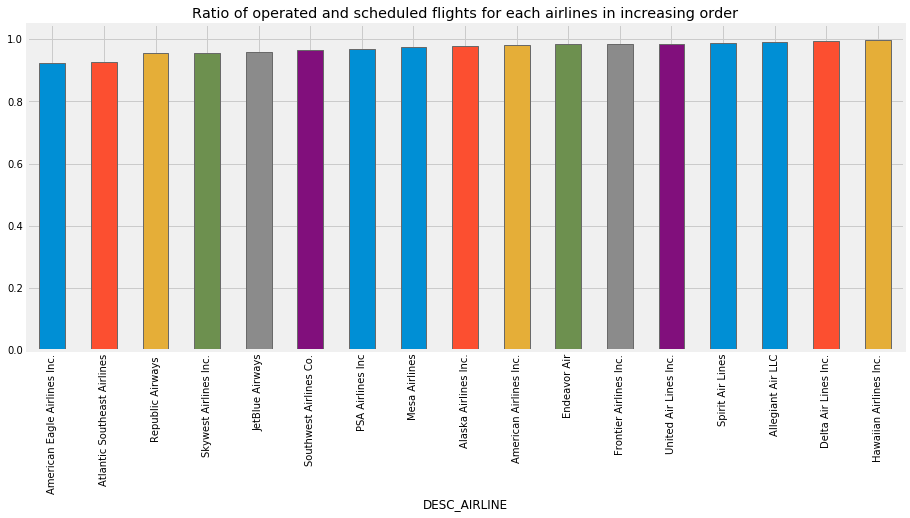

In [21]:
rank_airlines.sort_values(by=['RATIO_OP_SCH'],ascending = 1,inplace=True)
# rank_airlines.head()
# rank_airlines['RATIO_OP_SCH'].plot(kind='bar',figsize=(14,6),rot=45)
rank_airlines['RATIO_OP_SCH'].plot(kind='bar',figsize=(14,6))
plt.title('Ratio of operated and scheduled flights for each airlines in increasing order')

In [22]:
new_flights['FLIGHT_SPEED'] = 60*new_flights['DISTANCE']/new_flights['AIR_TIME']
rank_airlines['FLIGHT_SPEED'] = new_flights.groupby('DESC_AIRLINE')['FLIGHT_SPEED'].mean()

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001ED08689F28>]], dtype=object)

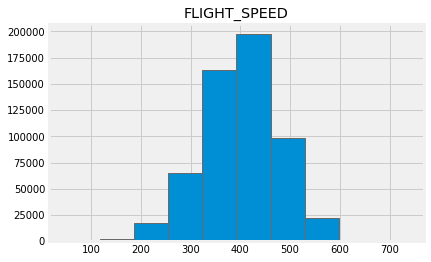

In [23]:
new_flights[['DESC_AIRLINE','FLIGHT_SPEED']].hist()

In [24]:
# print(new_flights.groupby('DESC_AIRLINE')[['ARRIVAL_DELAY','DEPARTURE_DELAY']].mean())
#add arrival delay to our ranking module as well.
rank_airlines['ARR_DELAY']= new_flights.groupby('DESC_AIRLINE')['ARRIVAL_DELAY'].mean()
#As our flight speed is in miles/hour,it's probably best to keep ARRIVAL DELAY in hours.
rank_airlines['ARR_DELAY']=rank_airlines['ARR_DELAY'].apply(lambda x:x/60)
rank_airlines.head()

,RATIO_OP_SCH,FLIGHT_SPEED,ARR_DELAY
DESC_AIRLINE,,,
American Eagle Airlines Inc.,0.924550,350.464111,0.132487
Atlantic Southeast Airlines,0.926942,358.178905,0.223699
Republic Airways,0.956047,371.108653,0.143684
Skywest Airlines Inc.,0.956551,361.173097,0.199919
JetBlue Airways,0.959907,420.323863,0.242625


[Text(0.5,0,'Mean flight delays (Arrival : Green,Departure : Yellow)')]

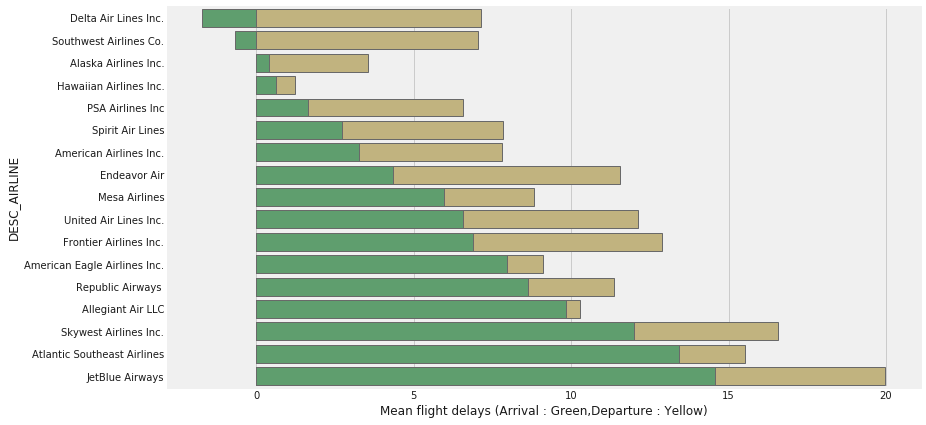

In [25]:
df_delay = pd.DataFrame(new_flights.groupby('DESC_AIRLINE')[['ARRIVAL_DELAY','DEPARTURE_DELAY']].mean())
df_delay.sort_values(by=['ARRIVAL_DELAY','DEPARTURE_DELAY'],ascending = [1,1],inplace=True)
plt.figure(figsize=(12,7))
sns.set_color_codes("deep")
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='DEPARTURE_DELAY',y=df_delay.index,data = df_delay,color = 'y')
plot = sns.barplot(x='ARRIVAL_DELAY',y=df_delay.index,data = df_delay,color = 'g')
plot.set(xlabel='Mean flight delays (Arrival : Green,Departure : Yellow)')

[Text(0.5,0,'Mean taxi out and in time (Taxi Out : Crimson,Taxi In : Cyan)')]

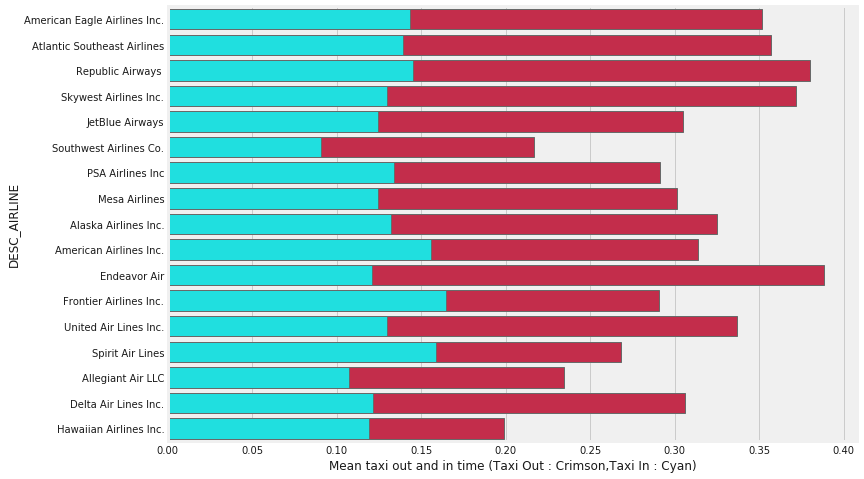

In [26]:
rank_airlines[['Taxi_IN','Taxi_OUT']] = new_flights.groupby('DESC_AIRLINE')[['TAXI_IN','TAXI_OUT']].mean()
#Taxi in and out time are in minutes.Let's change them to hours.
rank_airlines['Taxi_IN'] = rank_airlines['Taxi_IN'].apply(lambda x:(x/float(60)))
rank_airlines['Taxi_OUT'] = rank_airlines['Taxi_OUT'].apply(lambda x:(x/float(60)))
plt.figure(figsize=(11, 8))
sns.set_color_codes("deep")
sns.set_context(font_scale=2.5)
plot = sns.barplot(x='Taxi_OUT',y=rank_airlines.index,data = rank_airlines,color = 'crimson')
plot = sns.barplot(x='Taxi_IN',y=rank_airlines.index,data = rank_airlines,color = 'cyan')
plot.set(xlabel='Mean taxi out and in time (Taxi Out : Crimson,Taxi In : Cyan)')

Now,let's find the rank of a particular airline.

We have 5 variables which decide a score. The score is proportional to a subset (a) of the variables whereas being inversely proportional to a different subset (b) of the variables.
Score_airline = a/(1+b), where

    a = (RATIO_OP_SCH) \* (FLIGHT_SPEED)

    and 

    b = (ARRIVAL_DELAY) \* (TAXI_IN) \* (TAXI_OUT)
A higher score indicates a better rank.

In [27]:
#scaled the data to 1-2
# normalization
for i in rank_airlines.columns:
    rank_airlines[i] = ((rank_airlines[i]-rank_airlines[i].min())/(rank_airlines[i].max()-rank_airlines[i].min()))+1
a = rank_airlines.RATIO_OP_SCH*rank_airlines.FLIGHT_SPEED
b = rank_airlines.ARR_DELAY*rank_airlines.Taxi_IN*rank_airlines.Taxi_OUT
rank_airlines['SCORE'] = a/(1+b)
rank_airlines.sort_values(['SCORE'],ascending=False,inplace=True)
rank_airlines.head()

,RATIO_OP_SCH,FLIGHT_SPEED,ARR_DELAY,Taxi_IN,Taxi_OUT,SCORE
DESC_AIRLINE,,,,,,
Southwest Airlines Co.,1.537129,1.686413,1.063946,1.000000,1.093187,1.198393
Allegiant Air LLC,1.914493,1.942008,1.709650,1.222111,1.187039,1.068325
Delta Air Lines Inc.,1.954145,1.742623,1.000000,1.412503,1.564810,1.060754
Hawaiian Airlines Inc.,2.000000,1.107643,1.144646,1.387263,1.000000,0.856009
Alaska Airlines Inc.,1.735948,1.889142,1.130573,1.559719,1.666355,0.832684


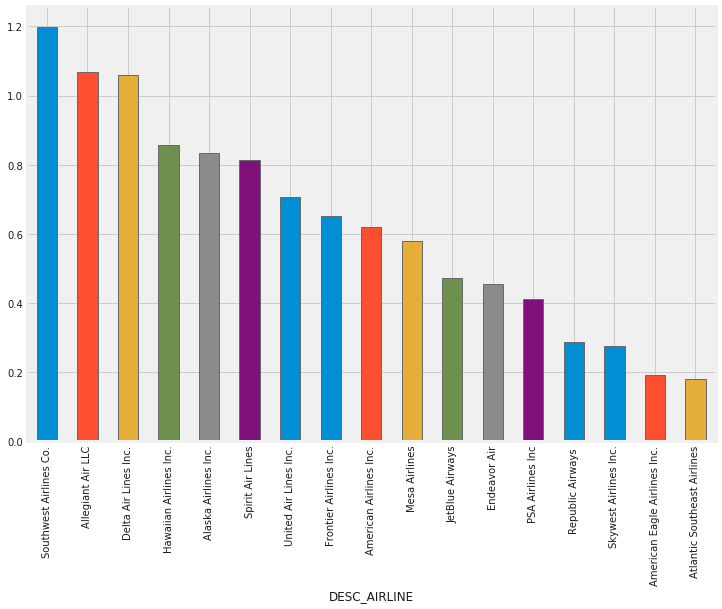

In [28]:
rank_airlines['SCORE'].plot.bar(figsize = (11,8))

## Predictive Modeling 

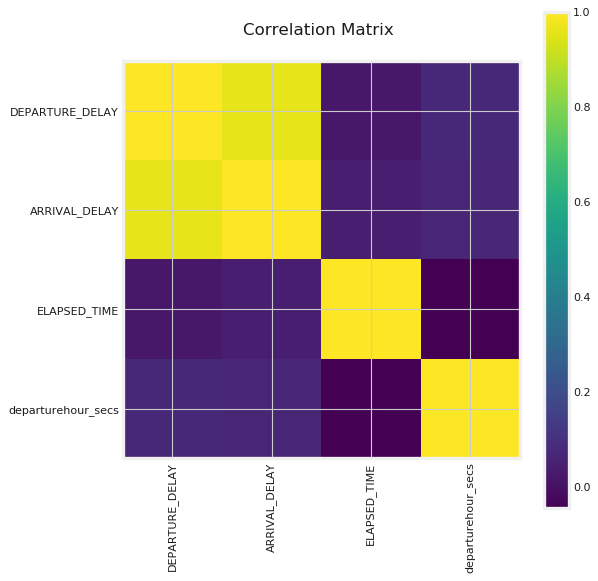

In [29]:

    
# Correlation matrix
def plotCorrelationMatrix(df, graphWidth):
    #filename = df.dataframeName
    #df = df.dropna('columns') # drop columns with NaN
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    if df.shape[1] < 2:
        print(f'No correlation plots shown: The number of non-NaN or constant columns ({df.shape[1]}) is less than 2')
        return
    corr = df.corr()
    plt.figure(num=None, figsize=(graphWidth, graphWidth), dpi=80, facecolor='w', edgecolor='k')
    corrMat = plt.matshow(corr, fignum = 1)
    plt.xticks(range(len(corr.columns)), corr.columns, rotation=90)
    plt.yticks(range(len(corr.columns)), corr.columns)
    plt.gca().xaxis.tick_bottom()
    plt.colorbar(corrMat)
    plt.title(f'Correlation Matrix ', fontsize=15)
    plt.show()

df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
df2['departurehour_hours'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())  
fct = lambda x:x.hour*3600+x.minute*60+x.second
df2['departurehour_secs'] = df2['departurehour_hours'].apply(fct)
    
plotCorrelationMatrix(df2, 8)

In [30]:
#SUPPORTING FUNCTIONS FOR PREDICTIVE MODELING

def get_flight_delays(df, carrier, id_airport, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier) & (df['ORIGIN_AIRPORT'] == id_airport)]

    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')
    
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['hour_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())

    test2 = df2['DEPARTURE_DELAY'].groupby(df2['hour_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)
    
    fct = lambda x:x.hour*3600+x.minute*60+x.second
    
    test2.reset_index(inplace=True)
    test2['hour_depart'] = test2['hour_depart'].apply(fct)
    return test2

def get_flight_delays_carrier(df, carrier, extrem_values = False):
    df2 = df[(df['AIRLINE'] == carrier)]

    # remove extreme values before fitting
    if extrem_values:
        df2['DEPARTURE_DELAY'] = df2['DEPARTURE_DELAY'].apply(lambda x:x if x < 60 else np.nan)
        df2.dropna(how = 'any')

    # Conversion: date + hour -> hour
    df2.sort_values('SCHEDULED_DEPARTURE', inplace = True)
    df2['hour_depart'] =  df2['SCHEDULED_DEPARTURE'].apply(lambda x:x.time())

    test2 = df2['DEPARTURE_DELAY'].groupby(df2['hour_depart']).apply(get_stats).unstack()
    test2.reset_index(inplace=True)

    fct = lambda x:x.hour*3600+x.minute*60+x.second
    test2['hour_depart'] = test2['hour_depart'].apply(fct)
    return test2

def get_stats(group):
    return {'min': group.min(), 'max': group.max(),
            'count': group.count(), 'mean': group.mean()}



In [31]:
   
def linear_regression(test2):
    test = test2[['mean', 'hour_depart']].dropna(how='any', axis = 0)
    X = np.array(test['hour_depart'])
    Y = np.array(test['mean'])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

    X_train = X_train.reshape(len(X_train),1)
    Y_train = Y_train.reshape(len(Y_train),1)
    X_test = X_test.reshape(len(X_test),1)
    Y_test = Y_test.reshape(len(Y_test),1)
    
    regr = linear_model.LinearRegression()
    regr.fit(X_train, Y_train)
    Y_modelout = regr.predict(X_test)
    
    return X_test, Y_test, Y_modelout,regr, X_train, Y_train

In [32]:
df2.head()

,AIRLINE,ORIGIN_AIRPORT,DESTINATION_AIRPORT,SCHEDULED_DEPARTURE,DEPARTURE_TIME,DEPARTURE_DELAY,SCHEDULED_ARRIVAL,ARRIVAL_TIME,ARRIVAL_DELAY,ELAPSED_TIME,departurehour_hours,departurehour_secs
494903,F9,DEN,TPA,2019-01-01 00:04:00,00:25:00,21.0,05:30:00,06:20:00,50.0,235.0,00:04:00,240
495007,F9,LAS,ATL,2019-01-01 00:05:00,00:28:00,23.0,06:57:00,07:04:00,7.0,216.0,00:05:00,300
541831,UA,SEA,IAH,2019-01-01 00:05:00,23:58:00,-7.0,06:14:00,06:07:00,-7.0,249.0,00:05:00,300
158645,AA,LAX,MIA,2019-01-01 00:15:00,00:18:00,3.0,08:10:00,08:07:00,-3.0,289.0,00:15:00,900
78198,AS,PHX,ANC,2019-01-01 00:15:00,00:05:00,-10.0,04:17:00,04:07:00,-10.0,362.0,00:15:00,900


The R2 val =  0.554823745572


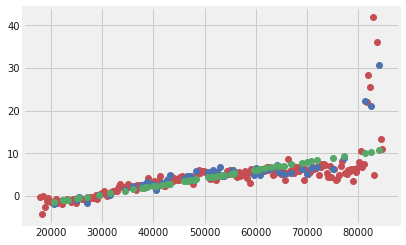

In [33]:
# across all airports
carrier = 'WN'

df3 = df2.copy()
test3 = get_flight_delays_carrier(df3, carrier, True) 
X_test, Y_test, Y_modelout,regr, X_train, Y_train = linear_regression(test3)

r2_val = r2_score(Y_test,Y_modelout)
print("The R2 val = " ,r2_val)

plt.scatter(X_train, Y_train,color = 'r')
plt.scatter(X_test, Y_test,color = 'b')

plt.scatter(X_test, Y_modelout,color = 'g')
plt.show()

# Add the legend, x and y axis 



In [34]:
def poly_regression(test2,in_degree):
    test = test2[['mean', 'hour_depart']].dropna(how='any', axis = 0)
    X = np.array(test['hour_depart'])
    Y = np.array(test['mean'])

    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.25, random_state=42)

    X_train = X_train.reshape(len(X_train),1)
    Y_train = Y_train.reshape(len(Y_train),1)
    X_test = X_test.reshape(len(X_test),1)
    Y_test = Y_test.reshape(len(Y_test),1)

    poly = PolynomialFeatures(degree=in_degree)
    X_train_ = poly.fit_transform(X_train)
    X_test_ = poly.fit_transform(X_test)

    regr = linear_model.LinearRegression()
    regr.fit(X_train_, Y_train)
    Y_modelout = regr.predict(X_test_)
    
    return X_test, Y_test, Y_modelout,regr, X_train, Y_train

The R2 val =  0.768450334793


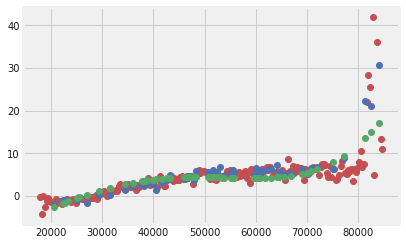

In [35]:
carrier = 'WN'

df3 = df2.copy()
test3 = get_flight_delays_carrier(df3, carrier, True)
X_test, Y_test, Y_modelout,regr, X_train, Y_train = poly_regression(test3,4)

r2_val = r2_score(Y_test,Y_modelout)
print("The R2 val = " ,r2_val)

plt.scatter(X_train, Y_train,color = 'r')
plt.scatter(X_test, Y_test,color = 'b')

plt.scatter(X_test, Y_modelout,color = 'g')
plt.show()

In [36]:
print('Done')

Done
